# Сегментирование входящих данных [0..1] в один класс в sigmoid

Проверим выделенные ресурсы для ноутбука

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
!pip install -q psutil
!pip install -q humanize
import psutil as ps # library for retrieving information on running processes and system utilization
import humanize as hm # library for turning a number into a fuzzy human-readable
import os # library for operations with operation system 
import GPUtil as GPU # access to GPU subsystem
GPUs = GPU.getGPUs() # get number of GPUs
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = ps.Process(os.getpid())
print(f'Gen RAM Free: {hm.naturalsize( ps.virtual_memory().available )} | Proc size: {hm.naturalsize( process.memory_info().rss )}')
print( 'GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util: {2:3.0f}% | Total: {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print(f'GPU Model: {gpu.name}')

Gen RAM Free: 26.1 GB | Proc size: 95.2 MB
GPU RAM Free: 16280MB | Used: 0MB | Util:   0% | Total: 16280MB
GPU Model: Tesla P100-PCIE-16GB


###Подключим библиотеки

In [ ]:
from tensorflow.keras.models import Model, load_model # модели керас
from tensorflow.keras.layers import Input, Conv2DTranspose, UpSampling2D, concatenate, Activation, Conv2D, MaxPooling2D, BatchNormalization, Maximum, Add # слои
from tensorflow.keras import backend as K # модуль backend кераса
from tensorflow.keras.optimizers import Adam # оптимайзеры 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # колбэки
from tensorflow.keras import utils # утилиты кераса для OHE
from google.colab import files # работа с файлами
import matplotlib.pyplot as plt # работа с графиками
import seaborn as sns # для цветовой палитры
from tensorflow.keras.preprocessing import image # работа с изображениями
import numpy as np # библиотека numpy
from sklearn.model_selection import train_test_split # деление на выборки
import time # библиотека работы с временем
import random # библиотека работы с генератором случайных чисел
import os # библиотека для работы с файловой системов ОС
from PIL import Image # работа с изображениями 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Функции и параметры

In [ ]:
# ДАТАСЕТЫ ЗДЕСЬ
# https://drive.google.com/drive/folders/1_gbYreFimuK0ICO5UIFFCUBWM5Th0OSj?usp=sharing

In [ ]:
# Unpack files
!unzip -q -o '/content/drive/MyDrive/faces1000segmented.zip' -d /content

In [ ]:
# параметры картинки
img_rows  = 256 #176       #352
img_cols  = 256 #240       #480
channels  = 3
img_shape = (img_rows, img_cols, channels)

# расположение папок с файлами
x_dir       = '/content/origin'   # основная выборка
y_dir       = '/content/segment'  # сегментированная выборка

**Функции конвертации и вывода картинок**

In [ ]:
# Функция визуализации сегментированных изображений xVal
def processVal(model, count = 5):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(25, 15)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_rows, img_cols, channels)))[0] # Предиктим картинку
    axs[0,i].imshow( (xVal[idx]*255).astype('uint8') )       # Отображаем оригинальное изображение        
    axs[1,i].imshow( (yVal[idx][:,:,0]*255).astype('uint8'), cmap='gray' )       # Отображаем сегменитрованную картинку из yVal
    axs[2,i].imshow( (predict[:,:,0]*255).astype('uint8'), cmap='gray' )  # Отображаем сегментированную картинку из предикта
  plt.show()

### (!) Подготовим выборки
Длительный процесс

In [ ]:
# общая база X и Y
X = []
Y = []
cur_time = time.time() # засекаем время

# проходим по файлам папки текущего класса (исходной и сегментированой сразу)
for x_filename, y_filename in zip(
                                  sorted(os.listdir(x_dir)),
                                  sorted(os.listdir(y_dir)),
                                  ):
  # исходная картинка (массив RGB)
  x = np.array( image.load_img(x_dir+'/'+x_filename, target_size=(img_rows,img_cols)) )
  # x = x.astype('float32') / 255 # нормируем картинку
  X.append(x) # добавим очередной X
  # сегментированная картинка (массив RGB)
  y = np.array( image.load_img(y_dir+'/'+y_filename, target_size=(img_rows,img_cols)) )
  y[:,:,0][(y[:,:,0]>0) | (y[:,:,1]>0) | (y[:,:,2]>0)] = 255 # запишем максимальное значение в красный канал во все НЕ черные пикселы
  y = np.delete(y, 1, 2) # удаление столбца следущего за красным (делаем для синего)
  y = np.delete(y, 1, 2) # удаление столбца следущего за красным (остался зеленый)
  # y = y.astype('float32') / 255 # нормируем картинку
  # y_ohe = rgbToohe(y, 1, num_classes) # конвертируем в OHE
  Y.append(y) # добавим очередной Y
  # каждые 100 шагов
  if len(Y) % 100 == 0: 
    print('Обработано сэмплов :', len(Y)) # выводим количество обработанных изображений

# преобразуем в numpy массивы
X  = np.array(X, dtype='uint8')
Y  = np.array(Y, dtype='uint8')

print()
print('Загрузка файлов завершена: ', round(time.time()-cur_time,2), 'c', sep='')
print('X.shape', X.shape)
print('Y.shape', Y.shape)

Обработано сэмплов : 100
Обработано сэмплов : 200
Обработано сэмплов : 300
Обработано сэмплов : 400
Обработано сэмплов : 500
Обработано сэмплов : 600
Обработано сэмплов : 700
Обработано сэмплов : 800
Обработано сэмплов : 900
Обработано сэмплов : 1000

Загрузка файлов завершена: 45.74c
X.shape (1000, 256, 256, 3)
Y.shape (1000, 256, 256, 1)


In [ ]:
# сохраним обработанные данные
# np.save('/content/drive/MyDrive/X-Сегментация_улыбокV2.npy', X)
# np.save('/content/drive/MyDrive/Y-Сегментация_улыбокV2.npy', Y)

### Загрузим подготовленные данные

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

219

In [ ]:
# загрузим обработанные данные
X = np.load('/content/drive/MyDrive/X-Сегментация_улыбокV2.npy')
X = X.astype('float32') / 255 # нормируем картинку
Y = np.load('/content/drive/MyDrive/Y-Сегментация_улыбокV2.npy') 
Y = Y.astype('float32') / 255 # нормируем картинку

In [ ]:
# подготовим выборки
xTrain, xVal, yTrain, yVal = train_test_split(X, Y, test_size=0.1)
print('xTrain.shape', xTrain.shape)
print('yTrain.shape', yTrain.shape)
print('xVal.shape', xVal.shape)
print('yVal.shape', yVal.shape)

xTrain.shape (900, 256, 256, 3)
yTrain.shape (900, 256, 256, 1)
xVal.shape (100, 256, 256, 3)
yVal.shape (100, 256, 256, 1)


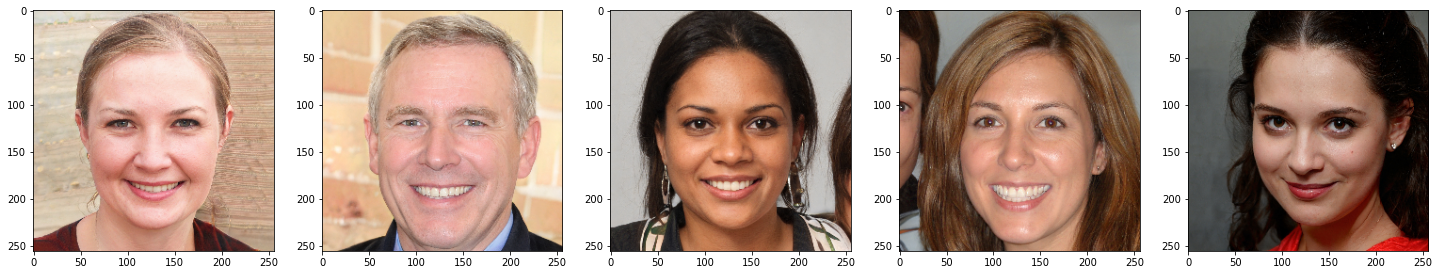

In [ ]:
# вывод случайных исходных картинок
n = 5
idxs = np.random.randint(0,xTrain.shape[0],n) # берем n случайных индексов
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i,idx in enumerate(idxs): # выводи в цикле n картинок
  axs[i].imshow( (xTrain[idx]*255).astype('uint8') ) # рисуем картинку
  # извлечем класс этой картинки (если классов много, то самый часто встречаемый пиксель и есть самый вероятный класс)
  # idx_arr = np.argmax(yTrain[idx],axis=2).flatten()                             # получим из массива картинки только индексы пикселей
  # idx_dict = {i:np.where(idx_arr==i)[0].shape[0] for i in range(1,num_classes)} # создадим словарь частотности каждого индекса (ичключая черный - 0)
  # idx_class = sorted(idx_dict.items(), key=lambda k:k[1], reverse=True)[0][0]   # результат сортировки список, берем нулевой кортеж, в нем нулевой элемент это наш самый частый индекс
  #
  # axs[i].axis('off') # Отключаем печать названия осей
  # axs[i].set_xlabel(f'Класс: {classes[idx_class]}')
plt.show() # вывод холста

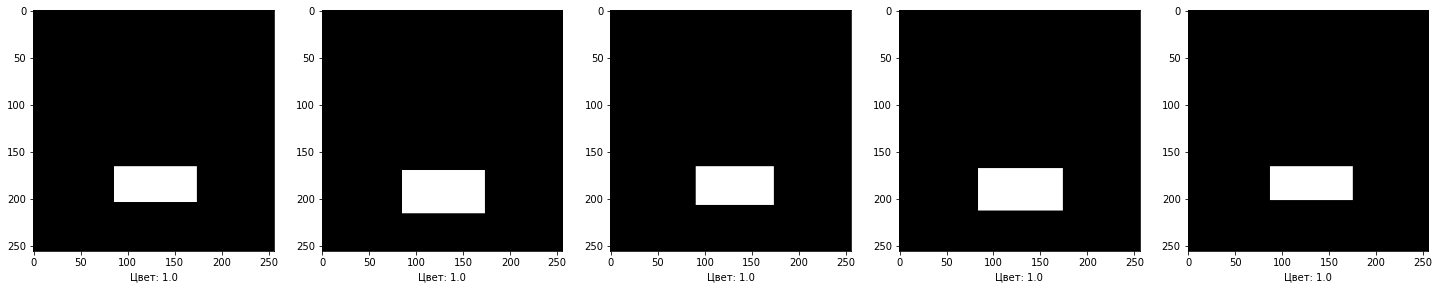

In [ ]:
# вывод сегментированных картинок для них
n = 5
# idxs = np.random.randint(0,xTrain.shape[0],n) # берем n случайных индексов
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i,idx in enumerate(idxs): # выводим в цикле n картинок
  img = yTrain[idx] # картинка 
  axs[i].imshow( (img[:,:,0]*255).astype('uint8'), cmap='gray' ) # рисуем картинку
  axs[i].set_xlabel(f'Цвет: {np.max(img)}')
plt.show() # вывод холста

### Гиперпараметры

In [ ]:
# колбэки # .hdf5
checkpoint = [
             ModelCheckpoint('/content/drive/MyDrive/Сегментация_улыбокV2.h5', 
             monitor='val_loss', 
             save_best_only=True)
             ]
early     = EarlyStopping(monitor='val_loss', patience=5, mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=0, mode='auto')

learning_rate = 1e-3 # шаг обучения
batch_size    = 32   # размер batch_size  

# функция метрики
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

### Функция создания модели

#### модель UNET 4 каскада вниз и 4 вверх

In [ ]:
# '''
#   Функция создания сети
#     Входные параметры:
#     - num_classes - количество классов
#     - input_shape - размерность карты сегментации
# '''
# def unet(num_classes = num_classes, input_shape= (img_rows, img_cols, channels)): 
#     img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

#     # Block 1 
#     x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)         # Добавляем Conv2D-слой с 64-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (256 x 256)
#     block_1_out1= Activation('relu')(x)                                    # Добавляем слой Activation и запоминаем в переменной block_1_out

#     x = MaxPooling2D()(block_1_out1)                                        # Добавляем слой MaxPooling2D

#     # Block 2 
#     x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)        # Добавляем Conv2D-слой с 128-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (128 x 128)
#     block_2_out1 = Activation('relu')(x)                                   # Добавляем слой Activation и запоминаем в переменной block_2_out

#     x = MaxPooling2D()(block_2_out1)                                        # Добавляем слой MaxPooling2D

#     # Block 3 
#     x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (64 x 64)
#     block_3_out1 = Activation('relu')(x)                                   # Добавляем слой Activation и запоминаем в переменной block_3_out

#     x = MaxPooling2D()(block_3_out1)                                        # Добавляем слой MaxPooling2D

#     # Block 4 - Bottom Line
#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)        # Добавляем Conv2D-слой с 256-нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     # (32 x 32)
#     block_4_out1 = Activation('relu')(x)                                   # Добавляем слой Activation и запоминаем в переменной block_4_out
#     x = block_4_out1 

#     # UP to 3
#     x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     # (64 x 64)
#     x = concatenate([x, block_3_out1])                                      # Объединем текущий слой со слоем block_3_out
#     x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(256, (3, 3), padding='same')(x)
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     # UP to 2
#     x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     # (128 x 128)
#     x = concatenate([x, block_2_out1])                                      # Объединем текущий слой со слоем block_2_out
#     x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
#     x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
#     x = Activation('relu')(x)                                              # Добавляем слой Activation

#     x = Conv2D(128, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 128 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     # UP to 1
#     x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     # (256 x 256)
#     x = concatenate([x, block_1_out1])  # Объединем текущий слой со слоем block_1_out
#     x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
#     x = BatchNormalization()(x) # Добавляем слой BatchNormalization
#     x = Activation('relu')(x) # Добавляем слой Activation

#     x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

#     model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

#     # Компилируем модель 
#     model.compile(optimizer=Adam(learning_rate=learning_rate),
#                   loss='categorical_crossentropy',
#                   metrics=[dice_coef])
    
#     return model # Возвращаем сформированную модель

#### Модель UNET 6 каскадов вниз и 6 вверх

In [ ]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def unet(input_shape=(img_rows, img_cols, channels)): 
    img_input = Input(input_shape)                                         # Создаем входной слой с размерностью input_shape

    # Block 1 
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input) # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_1_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (256 x 256)
    x = MaxPooling2D()(block_1_out1)  # (256 x 256) ->  (128 x 128)        # Добавляем слой MaxPooling2D

    # Block 2 
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)        # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_2_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (128 x 128)
    x = MaxPooling2D()(block_2_out1) # (128 x 128) -> (64 x 64)            # Добавляем слой MaxPooling2D

    # Block 3 
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)        # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_3_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (64 x 64)
    x = MaxPooling2D()(block_3_out1)  # (64 x 64) -> (32 x 32)             # Добавляем слой MaxPooling2D

    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)        # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_4_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (32 x 32)
    x = MaxPooling2D()(block_4_out1)  # (32 x 32) -> (16 x 16)             # Добавляем слой MaxPooling2D

    # Block 5
    x = Conv2D(1024, (3, 3), padding='same', name='block5_conv1')(x)        # Добавляем Conv2D-слой с 1024-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_5_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (16 x 16)
    x = MaxPooling2D()(block_5_out1)  # (16 x 16) -> (8 x 8)               # Добавляем слой MaxPooling2D

    # Block 6 - Bottom line
    x = Conv2D(2048, (3, 3), padding='same', name='block6_conv1')(x)        # Добавляем Conv2D-слой с 2048-нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    block_6_out1 = Activation('relu')(x)                                              # Добавляем слой Activation
    # (8 x 8)
    x = block_6_out1 

    # UP to 5 # (8 x 8) -> (16 x 16)  
    x = Conv2DTranspose(1024, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 1024 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (16 x 16)
    x = concatenate([x, block_5_out1])                                      # Объединем текущий слой со слоем block_5_out
    x = Conv2D(1024, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 4 # (16 x 16) -> (32 x 32)  
    x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 512 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (32 x 32)
    x = concatenate([x, block_4_out1])                                      # Объединем текущий слой со слоем block_4_out
    x = Conv2D(512, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 512 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 3 # (32 x 32) -> (64 x 64)
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (64 x 64)
    x = concatenate([x, block_3_out1])                                      # Объединем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 2 # (64 x 64) -> (128 x 128)
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)    # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # (128 x 128)
    x = concatenate([x, block_2_out1])                                      # Объединем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                             # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                            # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                              # Добавляем слой Activation

    # UP to 1 # (128 x 128) -> (256 x 256)
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x) # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    # (256 x 256)
    x = concatenate([x, block_1_out1])  # Объединем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x) # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x) # Добавляем слой BatchNormalization
    x = Activation('relu')(x) # Добавляем слой Activation

    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на num_classes-нейронов

    model = Model(img_input, x) # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель 
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[dice_coef])
    
    return model # Возвращаем сформированную модель

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_48 (BatchN  (None, 256, 256, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

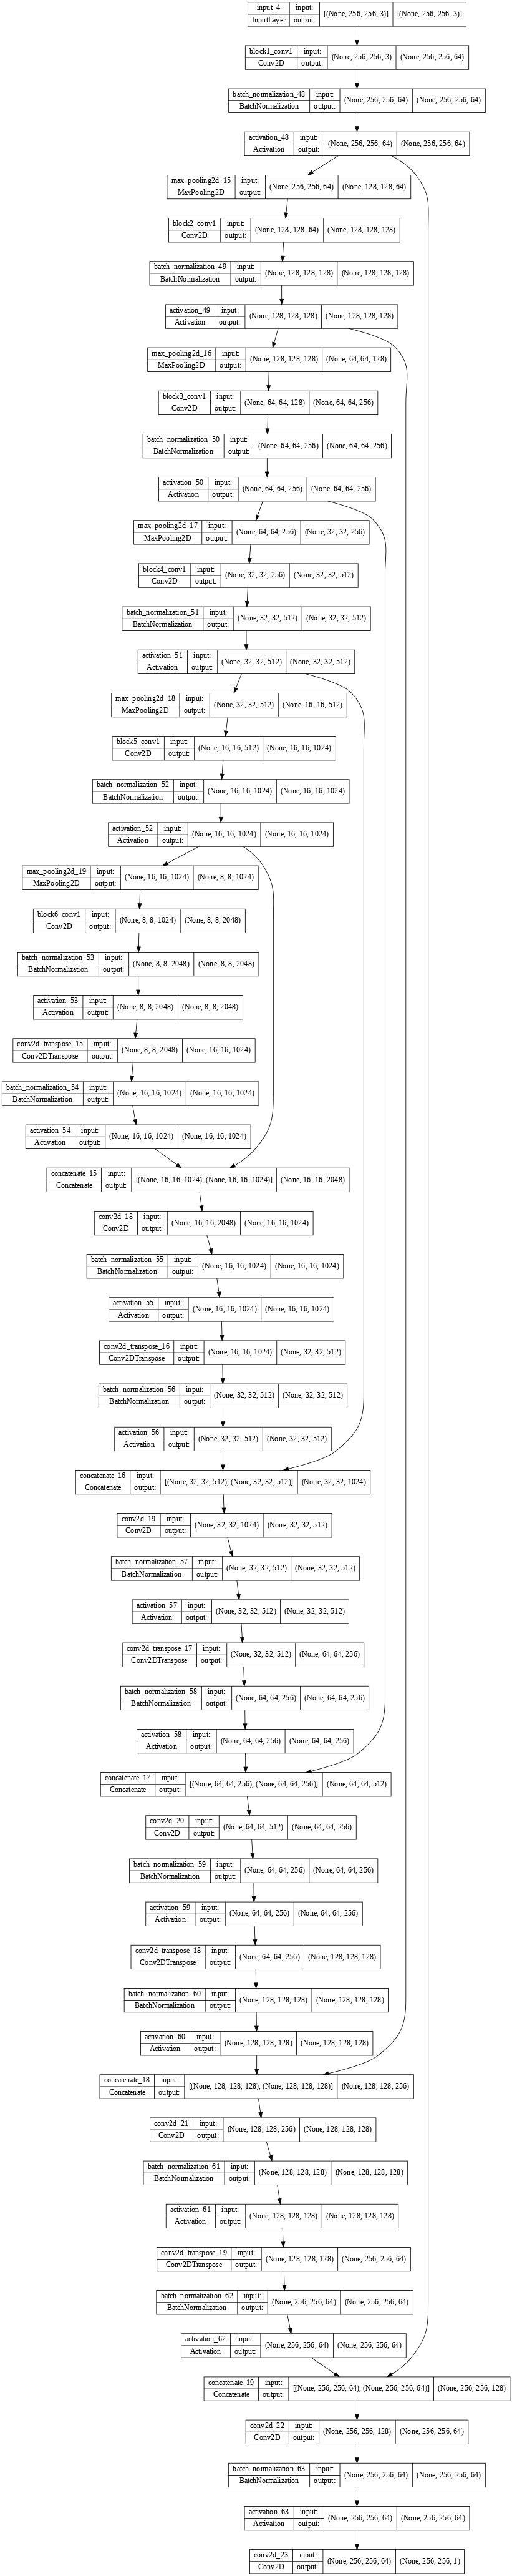

In [ ]:
learning_rate = 1e-3 # шаг обучения
batch_size    = 16   # размер batch_size  

model = unet()                                    # создание модели

model.summary()
utils.plot_model(model, dpi=60, show_shapes=True) # схема модели

### Обучение модели

In [ ]:
# чистим оперативную память
import gc    
gc.collect()

41006

In [ ]:
learning_rate = 1e-3 # шаг обучения
batch_size    = 16   # размер batch_size  

# Компилируем модель 
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[dice_coef])
# обучение модели
history = model.fit(xTrain, 
                    yTrain, 
                    epochs = 100,
                    batch_size = batch_size,
                    validation_data = (xVal, yVal),
                    verbose = 1,
                    callbacks=[
                                checkpoint,
                                early,
                                #lr_reduce,
                                ])


Epoch 1/100
57/57 [==============================] - 25s 368ms/step - loss: 0.2167 - dice_coef: 0.2163 - val_loss: 2.7460 - val_dice_coef: 1.9118e-05
Epoch 2/100
57/57 [==============================] - 23s 413ms/step - loss: 0.0489 - dice_coef: 0.7361 - val_loss: 0.3939 - val_dice_coef: 0.3041
Epoch 3/100
57/57 [==============================] - 20s 347ms/step - loss: 0.0345 - dice_coef: 0.8156 - val_loss: 0.1612 - val_dice_coef: 0.1630
Epoch 4/100
57/57 [==============================] - 18s 312ms/step - loss: 0.0290 - dice_coef: 0.8388 - val_loss: 0.1817 - val_dice_coef: 0.1244
Epoch 5/100
57/57 [==============================] - 18s 312ms/step - loss: 0.0268 - dice_coef: 0.8502 - val_loss: 0.3153 - val_dice_coef: 0.0180
Epoch 6/100
57/57 [==============================] - 23s 411ms/step - loss: 0.0259 - dice_coef: 0.8553 - val_loss: 0.0679 - val_dice_coef: 0.6008
Epoch 7/100
57/57 [==============================] - 20s 346ms/step - loss: 0.0255 - dice_coef: 0.8594 - val_loss: 0.044

In [ ]:
# Загрузить последние веса
model.load_weights('/content/drive/MyDrive/Сегментация_улыбокV2.h5')
# model = load_model('/content/drive/MyDrive/Сегментация_улыбокV2.h5', compile = True)

In [ ]:
# Дообучение модели

learning_rate = 1e-6 # шаг обучения
batch_size    = 16   # размер batch_size  

# Компилируем модель 
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=[dice_coef])
# обучение модели
history = model.fit(xTrain, 
                    yTrain, 
                    epochs = 100,
                    batch_size = batch_size,
                    validation_data = (xVal, yVal),
                    verbose = 1,
                    callbacks=[
                                checkpoint,
                                early,
                                #lr_reduce,
                                ])


Epoch 1/100
57/57 [==============================] - 24s 392ms/step - loss: 0.0234 - dice_coef: 0.8654 - val_loss: 0.0294 - val_dice_coef: 0.8510
Epoch 2/100
57/57 [==============================] - 20s 348ms/step - loss: 0.0231 - dice_coef: 0.8671 - val_loss: 0.0284 - val_dice_coef: 0.8534
Epoch 3/100
57/57 [==============================] - 20s 347ms/step - loss: 0.0228 - dice_coef: 0.8680 - val_loss: 0.0281 - val_dice_coef: 0.8544
Epoch 4/100
57/57 [==============================] - 18s 312ms/step - loss: 0.0227 - dice_coef: 0.8691 - val_loss: 0.0281 - val_dice_coef: 0.8549
Epoch 5/100
57/57 [==============================] - 18s 312ms/step - loss: 0.0225 - dice_coef: 0.8699 - val_loss: 0.0282 - val_dice_coef: 0.8551
Epoch 6/100
57/57 [==============================] - 18s 312ms/step - loss: 0.0225 - dice_coef: 0.8698 - val_loss: 0.0283 - val_dice_coef: 0.8551
Epoch 7/100
57/57 [==============================] - 18s 312ms/step - loss: 0.0225 - dice_coef: 0.8705 - val_loss: 0.0285 - 

### Оценим точность модели

In [ ]:
# оценить точность модели
scores = model.evaluate(xVal, yVal, verbose=0)
print('Точность модели: {:.2%}'.format(scores[1]))

Точность модели: 86.48%


In [ ]:
# Загрузить последние веса
# model.load_weights('/content/drive/MyDrive/Сегментация_улыбокV2.h5')
model = load_model('/content/drive/MyDrive/Сегментация_улыбокV2.h5', compile = False) # для продакшена compile = False, иначе нужны все остальные функции для модели

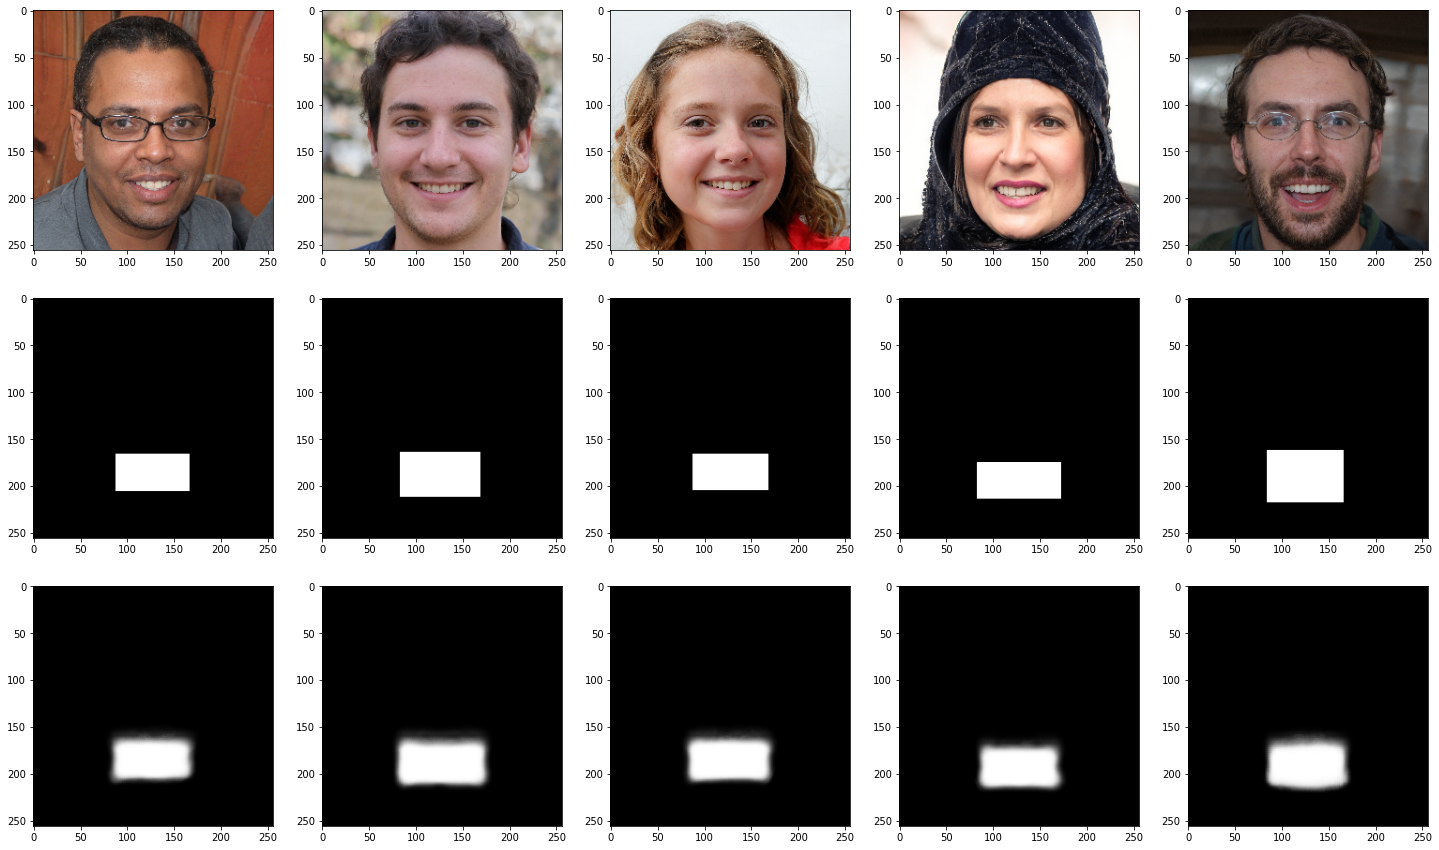

In [ ]:
# выберем для предикта 5 картинок валидационной выборки
processVal(model)

### Наложение маски

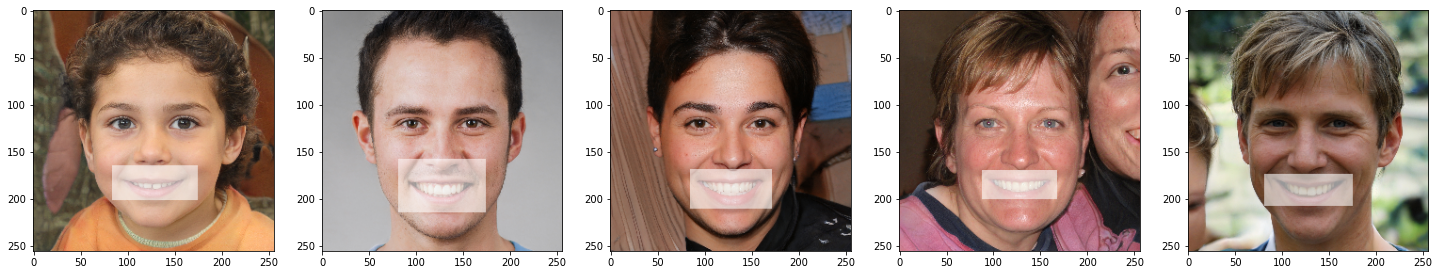

In [ ]:
# вывод картинок из валидационной выборки с маской
n = 5
idxs = np.random.randint(0,xVal.shape[0],n) # берем n случайных индексов
fig, axs = plt.subplots(1, n, figsize=(25,5))
for i,idx in enumerate(idxs): # выводи в цикле n картинок
  # формируем маску
  img = (yVal[idx]*255).astype('uint8') # картинка
  seg = Image.fromarray(img[:,:,0], mode='P').convert('RGBA') # сегментированная картинка для маски
  mask = np.array(seg) # переведем маску в numpy массив
  mask[mask[:,:,0]==0] = [0,0,0] + [0] # все черные пиксели оставим черными
  mask[mask[:,:,0]!=0] = [255,255,255] + [150] # оставим цвет класса + альфа канал 150
  img_mask = Image.fromarray(mask).convert('RGBA') # маска в RGBA
  # загрузим исходную картинку под маску
  img_main = Image.fromarray( (xVal[idx]*255).astype('uint8') )
  img_main.paste(img_mask, (0,0), img_mask)
  axs[i].imshow(img_main) # выводим очередную картинку с нанесенной маской
  # axs[i].axis('off') # Отключаем печать названия осей
  # axs[i].set_xlabel(f'Класс: {classes[idx_class]}')
plt.show() # вывод холста

### Попробуем распознать картинку из файла

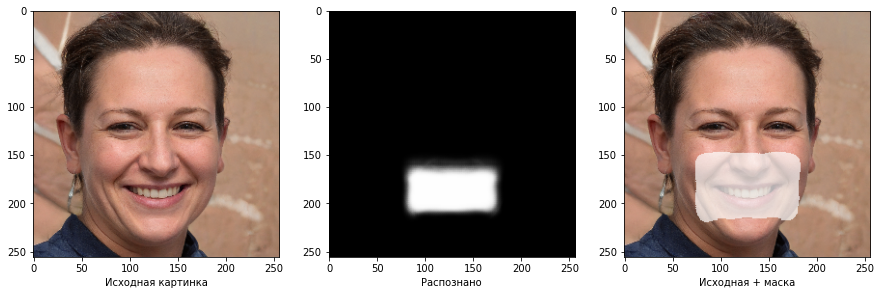

In [ ]:
filename = '/content/origin/0.jpg'
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) #Создаем полотно из n графиков
x = np.array( image.load_img(filename, target_size=(img_rows,img_cols)), dtype='uint8' ).astype('float32') / 255 # загружаем файл
axs[0].imshow( Image.fromarray((x*255).astype('uint8')).convert('RGBA') ) # выводим исходную картинку 
axs[0].set_xlabel('Исходная картинка') # подпишем класс
# x = x.reshape(1, img_rows, img_cols, channels) # решейпим в формат для предикта
predict = model.predict(x[None,...])[0] # предиктим
# вывод картинки предикта
axs[1].imshow( Image.fromarray((predict[:,:,0]*255).astype('uint8'), mode='P').convert('RGBA') ) # выводим картинку предикта
axs[1].set_xlabel('Распознано') # подпишем класс
# подготовим маску
img = (predict*255).astype('uint8') # картинка
seg = Image.fromarray(img[:,:,0], mode='P').convert('RGBA') # сегментированная картинка для маски
mask = np.array(seg) # переведем маску в numpy массив
mask[mask[:,:,0]==0] = [0,0,0] + [0] # все черные пиксели оставим черными
mask[mask[:,:,0]!=0] = [255,255,255] + [150] # оставим цвет класса + альфа канал 150
img_mask = Image.fromarray(mask).convert('RGBA') # маска в RGBA
# загрузим исходную картинку под маску
img_main = Image.fromarray((x*255).astype('uint8')).convert('RGBA')
img_main.paste(img_mask, (0,0), img_mask)
axs[2].imshow(img_main) # выводим очередную картинку с нанесенной маской
axs[2].set_xlabel('Исходная + маска') # подпишем класс

plt.show() # вывод

In [ ]:
# Функция оценки размера модели в памяти
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

In [ ]:
# Сколько модель занимает в памяти
print(get_model_memory_usage(batch_size, model), 'Gbytes')

5.717 Gbytes
